<a href="https://colab.research.google.com/github/vinhngx/DeepLearningExamples/blob/vinhn_unet_industrial_demo/TensorFlow/Segmentation/UNet_Industrial/notebooks/Colab_UNet_Industrial_TF_TFHub_inference_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# UNet Industrial Inference Demo with TensorFlow Hub

## Overview


In this notebook, we will demo the process of inference with  NVIDIA pre-trained UNet Industrial defects detection TensorFlow Hub modules.

NVIDIA pre-trained U-Net models for defect detection are adapted from the original version of the [U-Net model](https://arxiv.org/abs/1505.04597) which is
a convolutional auto-encoder for 2D image segmentation. U-Net was first introduced by
Olaf Ronneberger, Philip Fischer, and Thomas Brox in the paper:
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597).

### Requirement
1. Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.



In [0]:
!nvidia-smi

Wed Oct 23 12:47:56 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

The below code checks whether a Tensor-Core GPU is present.  Tensor Cores can accelerate large matrix operations by performing mixed-precision matrix multiply and accumulate calculations in a single operation. 

In [0]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


2. Next, we clone the NVIDIA Github UNet_Industrial repository and set up the workspace.

In [0]:
!git clone https://github.com/NVIDIA/DeepLearningExamples

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4151 (delta 33), reused 68 (delta 18), pack-reused 3987
Receiving objects: 100% (4151/4151), 31.46 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (1878/1878), done.


In [0]:
%%bash
cd DeepLearningExamples
git checkout master

Your branch is up to date with 'origin/master'.


Already on 'master'


In [0]:
import os

WORKSPACE_DIR='/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks'
os.chdir(WORKSPACE_DIR)
print (os.getcwd())

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks


In [0]:
!pip install tensorflow_hub==0.6.0

## Data download

We will first download some data for testing purposes, in particular, the [Weakly Supervised Learning for Industrial Optical Inspection (DAGM 2007)](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html) dataset. 

> The competition is inspired by problems from industrial image processing. In order to satisfy their customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.
>
> The competitors have to design a stand-alone algorithm which is able to detect miscellaneous defects on various background textures.
>
> The particular challenge of this contest is that the algorithm must learn, without human intervention, to discern defects automatically from a weakly labeled (i.e., labels are not exact to the pixel level) training set, the exact characteristics of which are unknown at development time. During the competition, the programs have to be trained on new data without any human guidance.

**Source:** https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


In [0]:
! ./download_and_preprocess_dagm2007_public.sh ./data

The final data directory should look like:

```
./data
  raw_images
      public
          Class1	    
          Class2	
          Class3	    
          Class4	
          Class5	    
          Class6
          Class1_def  
          Class2_def	
          Class3_def  
          Class4_def	
          Class5_def  
          Class6_def
      private
  zip_files
```

Each data directory contains training images corresponding to one of the first 6 types of defects.

## Load  UNet TF-Hub modules from Google Drive (Optional)

This step allow you to connect and load pretrained UNet TF-Hub modules from Google Drive. Execute the below cell to authorize Colab to access your Google Drive content, then copy the saved TF-Hub to Colab.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

In [0]:
!cp -r "/content/gdrive/My Drive/NVIDIA" .

In [0]:
!ls NVIDIA

## Inference with TF-Hub module

Next, we will load one of the pretrained UNet TF-Hub modules (corresponding to one of the 10 classes of the DAGM 2007 dataset) and carry out inference.

In order to load TF Hub modules, there are several options:

- Load from a local cache or directory

- Load from a remote repository

In [0]:
import tensorflow_hub as hub

# Loading from a local cache/directory
#module = hub.Module("NVIDIA/Unet/Class_1", trainable=False)

# Loading from a remote repository. The 10 NVIDIA UNet TF-Hub modules are available at
# https://developer.download.nvidia.com/compute/redist/Binary_Files/unet_tfhub_modules/class_{1..10}
module = hub.Module("https://developer.download.nvidia.com/compute/redist/Binary_Files/unet_tfhub_modules/class_1/1.tar.gz")  # or class_2, class_3 etc...

In [3]:
print(module.get_signature_names())

['default']


In [4]:
print(module.get_input_info_dict())   # When no signature is given, considers it as 'default'


{'images': <hub.ParsedTensorInfo shape=(?, 512, 512, 1) dtype=float32 is_sparse=False>}


In [5]:
print(module.get_output_info_dict())

{'default': <hub.ParsedTensorInfo shape=(?, 512, 512, 1) dtype=float32 is_sparse=False>}


In [0]:
# Load a test image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

plt.figure(figsize = (10,10));
plt.imshow(img, cmap='gray');

As we can see in this figure, there exists a defective area in the top left corner. We will now start a TF session and carry out inference on the normalized test image with the loaded TF-Hub module.

In [0]:
# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

output = module(img)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
print(output.shape)

(1, 512, 512, 1)


In [0]:
import tensorflow as tf
 
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
    pred = sess.run(output)
      

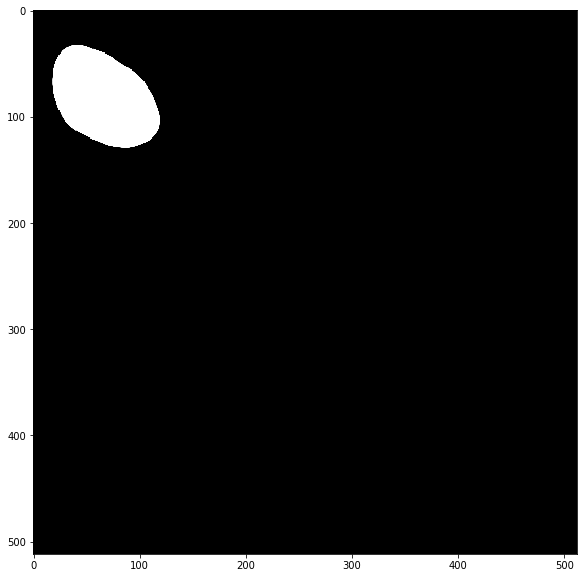

In [0]:
# Print out model predicted mask
plt.figure(figsize = (10,10));
plt.imshow(np.squeeze(pred), cmap='gray');

As expected, the TF-Hub module points out the correct defective area in this image. Please feel free to try out other defective images for Class 1 within `./data/raw_images/public/Class1_def/`, or load the other UNet modules and test data for other classes from 1 to 10. 

In [0]:
!ls ./data/raw_images/public/Class1_def/

100.png  116.png  131.png  147.png  26.png  41.png  57.png  72.png  88.png
101.png  117.png  132.png  148.png  27.png  42.png  58.png  73.png  89.png
102.png  118.png  133.png  149.png  28.png  43.png  59.png  74.png  8.png
103.png  119.png  134.png  14.png   29.png  44.png  5.png   75.png  90.png
104.png  11.png   135.png  150.png  2.png   45.png  60.png  76.png  91.png
105.png  120.png  136.png  15.png   30.png  46.png  61.png  77.png  92.png
106.png  121.png  137.png  16.png   31.png  47.png  62.png  78.png  93.png
107.png  122.png  138.png  17.png   32.png  48.png  63.png  79.png  94.png
108.png  123.png  139.png  18.png   33.png  49.png  64.png  7.png   95.png
109.png  124.png  13.png   19.png   34.png  4.png   65.png  80.png  96.png
10.png	 125.png  140.png  1.png    35.png  50.png  66.png  81.png  97.png
110.png  126.png  141.png  20.png   36.png  51.png  67.png  82.png  98.png
111.png  127.png  142.png  21.png   37.png  52.png  68.png  83.png  99.png
112.png  128.png  143.png  

# Conclusion

In this notebook, we have walked through the process of loading a pretrained UNet-Industrial TF-Hub module and carrying out inference on a test image.
## What's next
Now it's time to try the UNet-Industrial TF Hub modules on your own data. 